In [47]:
%pip install scikit-build
%pip install pyikarus  --no-build-isolation --verbose --upgrade
#!pip install pyzmq==19.0.2 --force-reinstall
#!pip install traitlets==4.3.3 --force-reinstall




Note: you may need to restart the kernel to use updated packages.
Using pip 23.0.1 from /dune/dune-common/build-cmake/dune-env/lib/python3.10/site-packages/pip (python 3.10)
Note: you may need to restart the kernel to use updated packages.


### Import all packages

In [48]:
import matplotlib
import pyikarus as iks
import pyikarus.finite_elements
import pyikarus.utils
import pyikarus.assembler
import pyikarus.dirichletValues
import numpy as np
import scipy as sp
from scipy.optimize import minimize

import dune.grid
import dune.functions
from dune.vtk import vtkUnstructuredGridWriter, vtkWriter, RangeTypes, FieldInfo

from dune.vtk import  vtkWriter


### Create grid

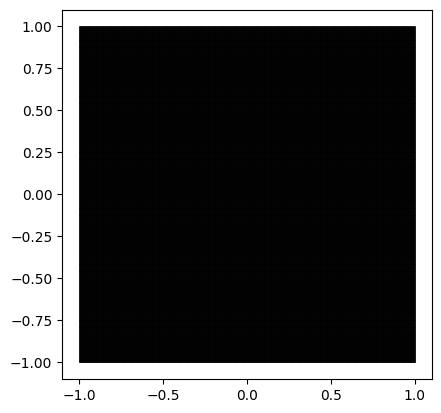

In [49]:
lowerLeft = [-1,-1]
upperRight = [1,1]
elements = [3,3]

grid = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
grid.hierarchicalGrid.globalRefine(7)
grid.plot()

### Add Lagrangian basis

In [50]:
basisLagrange1 = dune.functions.defaultGlobalBasis(grid, dune.functions.Power(dune.functions.Lagrange(order=1),2))
print('We have {} dofs.'.format(len(basisLagrange1)))
print('We have {} vertices.'.format(grid.size(2)))
print('We have {} elements.'.format(grid.size(0)))

We have 296450 dofs.
We have 148225 vertices.
We have 147456 elements.


### Init load factor and displacement vector

In [51]:
d = np.zeros(len(basisLagrange1))
lambdaLoad = iks.ValueWrapper(3.0)

### Define volume load and boundary loads

In [52]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*10, lambdaVal*10])

neumannVertices = np.zeros(grid.size(2)*2, dtype=bool)
basisLagrange1.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)

boundaryPatch = iks.utils.boundaryPatch(grid,neumannVertices)

### Create material

In [53]:
svk = iks.StVenantKirchhoff(emodul=1000,nu=0.3)

svkPS = svk.asPlainStress()

### Create vector of finite elements

In [54]:
fes = []
for e in grid.elements:
    fes.append(iks.finite_elements.nonLinearElasticElement(basisLagrange1,e,svkPS,volumeLoad,boundaryPatch,neumannLoad))

### Create Dirichlet boundary conditions

In [55]:
dirichletValues = iks.dirichletValues(basisLagrange1) 

def fixBottomEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]==-1):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixBottomEdge)

### Create assembler

In [56]:
assembler = iks.assembler.sparseFlatAssembler(fes,dirichletValues)

### Define functions

In [57]:
def energy(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getScalar(req)

def gradient(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.VectorAffordances.forces)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getReducedVector(req)

def hess(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.MatrixAffordances.stiffness)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getReducedMatrix(req)

def gradAndhess(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.MatrixAffordances.stiffness)
    req.addAffordance(iks.VectorAffordances.forces)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    g = assembler.getReducedVector(req)
    h = assembler.getReducedMatrix(req)  
    return [g, h]

### Solve using scipy

In [58]:
from numpy.linalg import norm
maxiter = 100
abs_tolerance = 1e-8
d = np.zeros(assembler.reducedSize())
for k in range(maxiter):
    R, K = gradAndhess(d)
    r_norm = norm(R)
    
    deltad = sp.sparse.linalg.spsolve(K, R)
    d -= deltad
    print(k,r_norm,norm(deltad),energy(d))
    if r_norm < abs_tolerance:
        break

print("Energy at equilibrium: ",energy(d))    

KeyboardInterrupt: 

In [ ]:
#dRed0 = np.zeros(assembler.reducedSize())

#sp.optimize.show_options("root","hybr")
#from scipy.optimize.nonlin import nonlin_solve
#from scipy.optimize import fsolve
#result = nonlin_solve(gradient,dRed0,hess, line_search=False)
#result = fsolve(gradient,dRed0,fprime=hess)
#print(result)
#result = minimize(energy,x0=dRed0,options={"disp": True},tol=1e-14)
#result = minimize(energy,x0=dRed0,jac=gradient,options={"disp": True})
#result = minimize(energy,method="trust-krylov",x0=dRed0,jac=gradient,hessp=hess,options={ 'disp': True, 'inexact': True})
#result = sp.optimize.root(gradient,jac=hess,x0=dRed0,tol=1e-10)

In [ ]:
#print(result)

fullDisp = assembler.createFullVector(d)

dispFunc = basisLagrange1.asFunction(fullDisp)

writer = vtkWriter( grid, "nameTestNonlinear",  pointData   = {( "displacement",(0,1)):dispFunc})

### Plot here using matplot lib

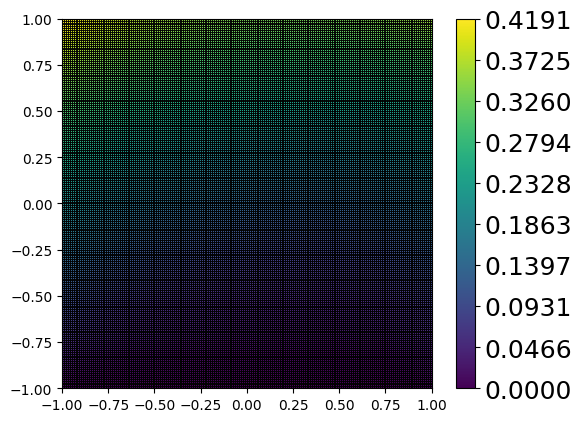

In [ ]:
import dune.plotting
dune.plotting.plot(solution=dispFunc)